## **Boundary Conditions**

### *Megan Sharkey* <br>
#### In this notebook, I create the boundary conditions for my model of Nuup Kangerlua. This notebook reads in 2017 ECCO files for ocean velocity and ocean temp/salinity. Using my model grid and bathymetry, I then generate the boundary conditions files for my model. I exclude the eastern boundary because it is all land in my model grid. 

First, import all packages needed to run the boundary conditions:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import vertical
from eccoseas.ecco import grid
from eccoseas.downscale import hFac
from eccoseas.downscale import horizontal

Next, include the file path to the data necessary to run the model code:

In [2]:
# define the input directory
input_dir = os.getcwd()

Identify the year of interest:

Here I chose to analyze 2017 because it is the most recent data available on the ECCO site. 

Eventually I will use the 2019 data because it has the most complete and accurate observational data available for Western Greenland.

In [3]:
year = 2017

In [4]:
# define the input directory
input_dir = os.getcwd()
data_folder = os.path.join(os.getcwd(), 'ecco_2017_data')

Read in the ECCO fields:

In [5]:
ds = nc4.Dataset('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_XC_tiles = ds.variables['XC'][:,:,:]
ecco_YC_tiles = ds.variables['YC'][:,:,:]
ecco_hFacC_tiles = ds.variables['hFacC'][:,:,:,:]
ecco_hFacS_tiles = ds.variables['hFacS'][:,:,:,:]
ecco_hFacW_tiles = ds.variables['hFacW'][:,:,:,:]
ecco_RF_tiles = ds.variables['Z'][:]
ecco_DRF = ds.variables['drF'][:]
ds.close()

FileNotFoundError: [Errno 2] No such file or directory: 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'

Define the grid parameters for this model:<br>

Here I used the bathymetry data generated in previous homework assignments

In [24]:
# define the parameters that will be used in the data file
XC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/XC720_540.bin', '>f8').reshape(720, 1)
#print(XC)
YC = np.fromfile('/Users/msharkey/Documents/MLML/FALL 2025/MS 274/lectures/week 8/my_model/YC720_540.bin', '>f8').reshape(540, 1)
#print(YC)
delX = 3.595/720
delY = 1.078/540
xgOrigin = -52.8
ygOrigin = 63.8
n_rows = 540
n_cols = 720

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'Greenland_bathymetry.bin'),'>f4').reshape(np.shape(XC))

Next, mask the data to prepare for interpolation:

In [25]:
depth = bathy
delR = np.array([1.00,    1.14,    1.30,    1.49,   1.70,
          1.93,    2.20,    2.50,    2.84,   3.21,
          3.63,    4.10,    4.61,    5.18,   5.79,
          6.47,    7.20,    7.98,    8.83,   9.73,
         10.69,   11.70,   12.76,   13.87,  15.03,
         16.22,   17.45,   18.70,   19.97,  21.27,
         22.56,   23.87,   25.17,   26.46,  27.74,
         29.00,   30.24,   31.45,   32.65,  33.82,
         34.97,   36.09,   37.20,   38.29,  39.37])
Z = np.cumsum(delR)
hFacC = hFac.create_hFacC_grid(depth, delR)

In [26]:
mask = np.copy(hFacC)
mask[mask>0] = 1

Plot this masked version next to normal bathymetry to double check:

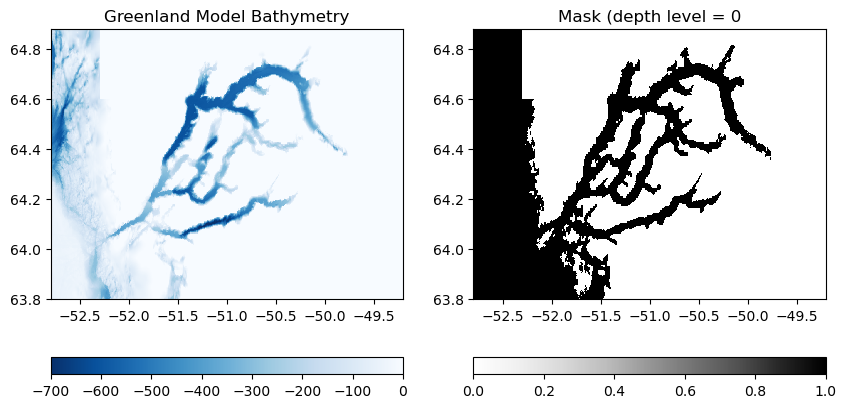

In [27]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-700, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Greenland Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

### **Interpolation Prep:**

Here, I am preparing the grid for interpolation. First, I check to see that my region is located on tile 10.

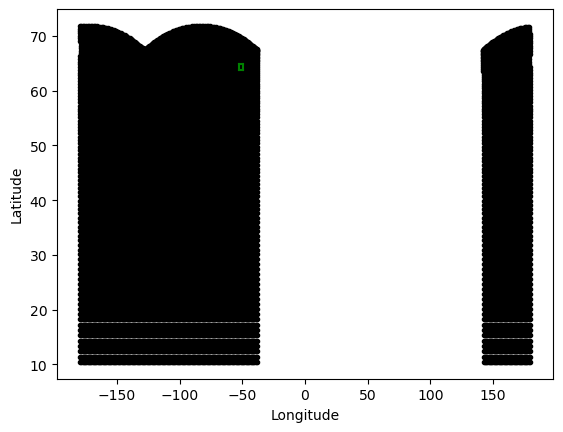

In [28]:
# plot the ECCO tile points from tile 10
plt.plot(ecco_XC_tiles[10],ecco_YC_tiles[10],'k.')
plt.plot(ecco_XC_tiles[7],ecco_YC_tiles[7],'k.')

# plot the boundary of the Greenland model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Now I'm reading in points from just tile 10, because that is the only tile necessary for this region of Greenland. 

In [29]:
tile_list = [10]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles)):
        level_hFacC = ecco_hFacC_tiles[k, tile_number, :, :]
        level_hFacW = ecco_hFacW_tiles[k, tile_number, :, :]
        level_hFacS = ecco_hFacS_tiles[k, tile_number, :, :]
        level_mask_C = np.copy(level_hFacC)
        level_mask_C[level_mask_C>0] = 1
        level_mask_W = np.copy(level_hFacW)
        level_mask_W[level_mask_W>0] = 1
        level_mask_S = np.copy(level_hFacS)
        level_mask_S[level_mask_S>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_maskC_points[k,points_counted:points_counted+tile_N] = level_mask_C.ravel()
        ecco_maskW_points[k,points_counted:points_counted+tile_N] = level_mask_W.ravel()
        ecco_maskS_points[k,points_counted:points_counted+tile_N] = level_mask_S.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, in order to read in the ECCO data for temperature, salinity, and velocity, I need to create a dictionary to store the file names:

In [30]:
# make a file dictionary to loop over
file_prefix_dict = {'THETA':'OCEAN_TEMPERATURE_SALINITY_mon_mean',
                    'SALT':'OCEAN_TEMPERATURE_SALINITY_mon_mean',
                    'UVEL':'OCEAN_VELOCITY_mon_mean',
                    'VVEL':'OCEAN_VELOCITY_mon_mean'}

variable_names = list(file_prefix_dict.keys())

Then I read in the fields from this data:

NOTE: I also interpolate vertically!


In [31]:
# make a list to hold all of the ECCO grids
BC_grids = []
timesteps = 12 # data is monthly

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    # create a grid of zeros to fill in
    N = 90*90
    BC_grid = np.zeros((timesteps, np.size(ecco_RF_tiles), N*len(tile_list)))

    for timestep in range(timesteps):
    
        if 'VEL' in variable_name:
            ds = nc4.Dataset(os.path.join(data_folder,
                                          file_prefix_dict['UVEL']+'_'+
                                          str(year)+'-'+'{:02d}'.format(timestep+1)+
                                         '_ECCO_V4r4_native_llc0090.nc'))
            u_grid = ds.variables['UVEL'][:,:,:,:,:]
            v_grid = ds.variables['VVEL'][:,:,:,:,:]
            ds.close()
        else:
            ds = nc4.Dataset(os.path.join(data_folder,
                                          file_prefix_dict[variable_name]+'_'+
                                          str(year)+'-'+'{:02d}'.format(timestep+1)+
                                         '_ECCO_V4r4_native_llc0090.nc'))
            grid = ds.variables[variable_name][:,:,:,:,:]
            ds.close()
        
        # loop through the tiles
        points_counted = 0
        for tile_number in tile_list:
            if 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
                if variable_name == 'UVEL':
                    if tile_number<6:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 u_grid[0, k, tile_number, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 v_grid[0, k, tile_number, :, :].ravel()
                if variable_name == 'VVEL':
                    if tile_number<6:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 v_grid[0, k, tile_number, :, :].ravel()
                    else:
                        for k in range(np.size(ecco_RF_tiles)):
                            BC_grid[timestep, k,points_counted:points_counted+N] = \
                                 -1*u_grid[0, k, tile_number, :, :].ravel()
            else:
                for k in range(np.size(ecco_RF_tiles)):
                    BC_grid[timestep, k,points_counted:points_counted+N] = \
                         grid[0, k, tile_number, :, :].ravel()
            points_counted += N

    
    # remove the points with positive longitudes
    BC_grid = BC_grid[:,:,local_indices]
    BC_grid_interpolated = np.zeros((timesteps, np.size(delR), np.shape(BC_grid)[-1]))
    for timestep in range(timesteps):
        temp_grid, _ = \
        vertical.interpolate_var_grid_faces_to_new_depth_levels(BC_grid[timestep,: ,:], ecco_maskC_points,
                                                                np.array(ecco_DRF), np.array(delR))
        BC_grid_interpolated[timestep,: ,:] = temp_grid
    
    BC_grids.append(BC_grid_interpolated)

## **Interoplating the Fields onto the Greenland Model Grid**

In this next section, I will interpolate the ECCO external fields read in above. I will use both *horizontal* and *vertical* packages from the eccoseas to do this. 

In [32]:
# define the boundary list for the model
boundary_list = ['west','south','north']

In [33]:
if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir,'obcs'))

In [34]:
# loop through each boundary
for boundary in boundary_list:
    print(' - Creating conditions on the '+str(boundary)+' boundary')

    if boundary == 'west':
        boundary_XC = XC[:,:1]
        boundary_YC = YC[:,:1]
        boundary_mask = mask[:,:,:1]
    elif boundary == 'east':
        boundary_XC = XC[:,-1:]
        boundary_YC = YC[:,-1:]
        boundary_mask = mask[:,:,-1:]
    elif boundary == 'north':
        boundary_XC = XC[-1:,:]
        boundary_YC = YC[-1:,:]
        boundary_mask = mask[:,-1:,:]
    elif boundary == 'south':
        boundary_XC = XC[:1,:]
        boundary_YC = YC[:1,:]
        boundary_mask = mask[:,:1,:]
    else:
        raise ValueError('Boundary '+boundary+' not recognized')

    # loop through each variable and corresponding ECCO grid
    for variable_name, BC_grid in zip(variable_names, BC_grids):

        if variable_name == 'UVEL':
            ecco_mask_points = ecco_maskS_points
        elif variable_name == 'VVEL':
            ecco_mask_points = ecco_maskW_points
        else:
            model_mask = mask
            ecco_mask_points = ecco_maskC_points

        output_grid = np.zeros((timesteps, np.size(delR), np.size(boundary_XC)))
    
        # print a message to keep track of which variable we are working on
        print('    - Interpolating the '+variable_name+' grid')

        for t in range(timesteps):
            print('       - Timestep:',t)

            interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                               BC_grid[t,:,:], ecco_mask_points, 
                                                               boundary_XC, boundary_YC, boundary_mask)
            for k in range(len(delR)):
                output_grid[t,k,:] = interpolated_grid[k,:,:].ravel()
    
        # output the interpolated grid
        output_file = os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_'+str(year))
        output_grid.ravel('C').astype('>f4').tofile(output_file)

 - Creating conditions on the west boundary
    - Interpolating the THETA grid
       - Timestep: 0
       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11
    - Interpolating the SALT grid
       - Timestep: 0
       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11
    - Interpolating the UVEL grid
       - Timestep: 0
       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11
    - Interpolating the VVEL grid
       - Timestep: 0
       - Timestep: 1
       - Timest

## **Plotting the Boundary Fields**

Now that the interpolation is complete, I will plot the fields below:

In [35]:
meta_dict = {'THETA':[-2, 6, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.1, 0.1, 'seismic', 'm'],
            'VVEL':[-0.1, 0.1, 'seismic', 'm']}

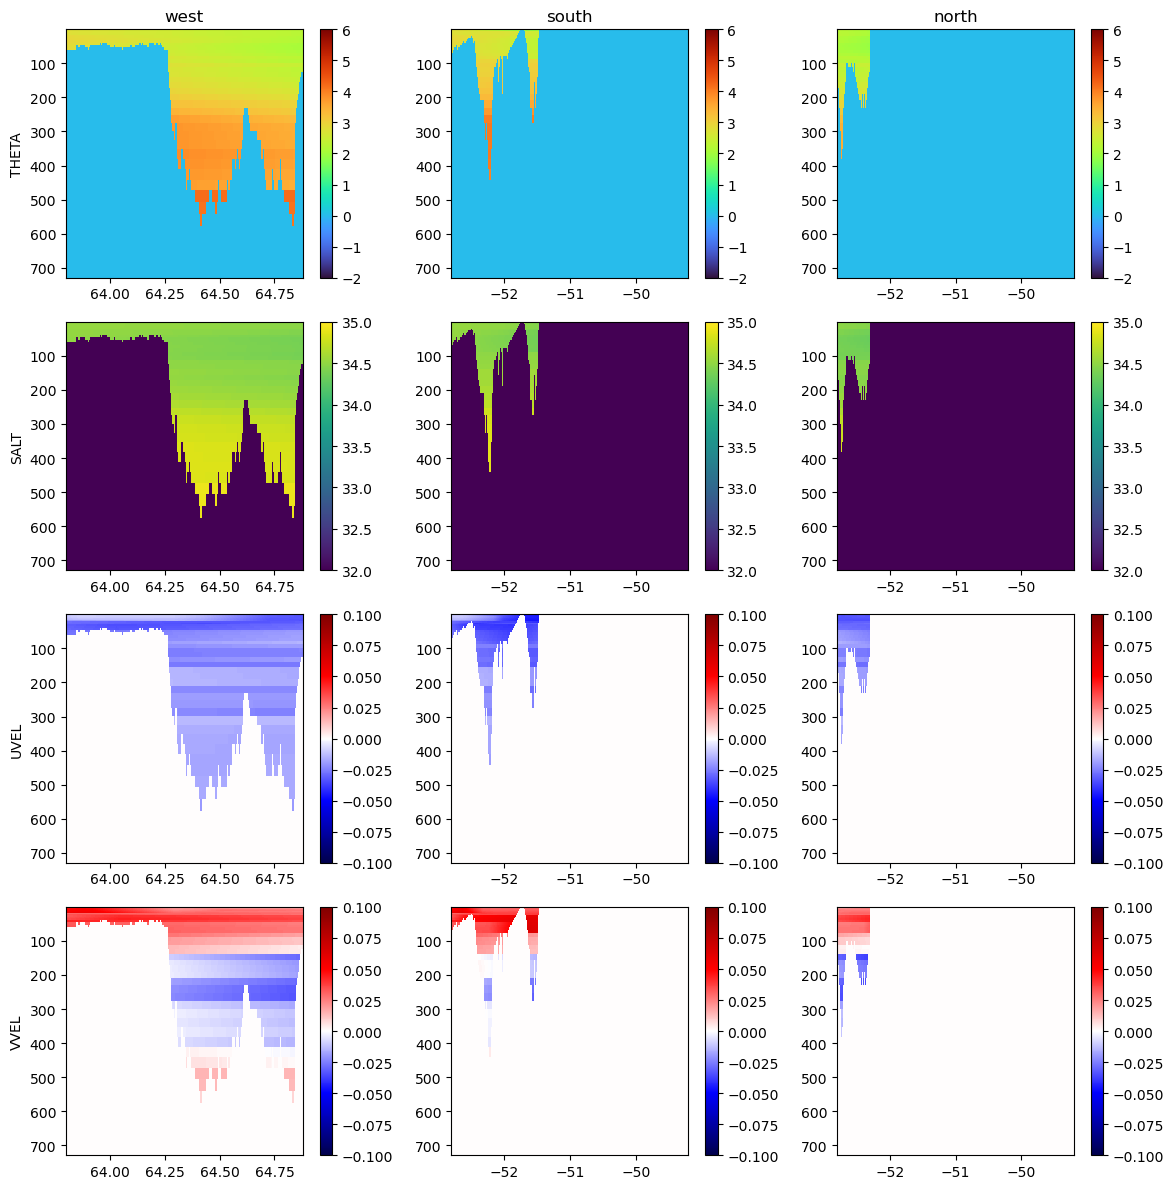

In [36]:
fig = plt.figure(figsize=(12,12))


plot_counter = 0
for i in range(len(variable_names)):
    variable_name = variable_names[i]
    
    for boundary in boundary_list:
        
        boundary_grid = np.fromfile(os.path.join(input_dir,'obcs',variable_name+'_'+boundary+'_2017'),'>f4')
    
        if boundary in ['west','east']:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[0]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='west':
                x = YC[:,1]
            if boundary=='east':
                x = YC[:,-1]
        else:
            boundary_grid = boundary_grid.reshape((timesteps, np.shape(delR)[0],np.shape(XC)[1]))
            boundary_grid = boundary_grid[0, :, :] # choose just the first timestep for plotting
            if boundary=='north':
                x = XC[-1,:]
            if boundary=='south':
                x = XC[1,:]

        plot_counter += 1
        plt.subplot(len(variable_names),len(boundary_list),plot_counter)
        C = plt.pcolormesh(x, Z, boundary_grid,
                           vmin=meta_dict[variable_names[i]][0],
                           vmax=meta_dict[variable_names[i]][1],
                           cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C,fraction=0.26)
        plt.gca().invert_yaxis()
    
        if plot_counter%3==1:
            plt.ylabel(variable_name)
        if plot_counter<4:
            plt.title(boundary)

plt.tight_layout()

plt.show()

### Step 7: Run-time considerations
To use the grids as boundary conditions in the model, I will use the `obcs` package - short for Open Boundary Condtions. To ensure the boundary conditions are included in the model, I will add a line for `obcs` in my `code/packages.conf` compile time file.

Next, I will add a line with ` useOBCS=.TRUE.` to the `data.pkg` file and a new file called `data.obcs` to my run directory. See Canvas for an editable `data.obcs` file.